# Importing packages #

In [1]:
import imageio 
import matplotlib.pyplot as plt
import cv2
import os
import glob
import shutil
from sklearn.model_selection import train_test_split


# Data Loading and Pipline #

In [2]:
def get_speaker_dirs(raw_dir):
    return [os.path.join(raw_dir, d) for d in os.listdir(raw_dir)
            if os.path.isdir(os.path.join(raw_dir, d))]

In [3]:
def create_video_folder_for_speaker(speaker_dir):
    
    speaker_name = os.path.basename(speaker_dir)
    part1_dir = os.path.join(speaker_dir, f"{speaker_name}.mpg_6000.part1")
    part2_dir = os.path.join(speaker_dir, f"{speaker_name}.mpg_6000.part2")

    part1_video = os.path.join(part1_dir, speaker_name, "video", "mpg_6000")
    part2_video = os.path.join(part2_dir, speaker_name, "video", "mpg_6000")
    
    dest_video = os.path.join(speaker_dir, "video")
    os.makedirs(dest_video, exist_ok=True)
    
   
    for src_video in glob.glob(os.path.join(part1_video, "*.mpg")):
        shutil.copy(src_video, dest_video)
        print(f"Copied {src_video} to {dest_video}")
    for src_video in glob.glob(os.path.join(part2_video, "*.mpg")):
        shutil.copy(src_video, dest_video)
        print(f"Copied {src_video} to {dest_video}")
    
    return dest_video


In [4]:
def process_speaker(speaker_dir, char_to_int):
    processed_list = []
    align_dir = os.path.join(speaker_dir, "align")
    
    for part in [f"{os.path.basename(speaker_dir)}.mpg_6000.part1", 
                 f"{os.path.basename(speaker_dir)}.mpg_6000.part2"]:
        video_dir = os.path.join(speaker_dir, part, os.path.basename(speaker_dir), "video", "mpg_6000")
        for video_file in glob.glob(os.path.join(video_dir, "*.mpg")):
            video_basename = os.path.splitext(os.path.basename(video_file))[0]  # e.g.: bbaf2n
            
            temp_processed = os.path.join(speaker_dir, "preprocessed")
            os.makedirs(temp_processed, exist_ok=True)
            video_output = os.path.join(temp_processed, video_basename)
            os.makedirs(video_output, exist_ok=True)
            
            alignment_file = os.path.join(align_dir, video_basename + ".align")
            if os.path.exists(alignment_file):
                # Process the alignment to get transcript and encoded version
                transcript, encoded = preprocess_alignment(alignment_file, char_to_int)
                # Save the transcript and encoded version to files
                with open(os.path.join(video_output, "transcript.txt"), "w") as f:
                    f.write(transcript)
                with open(os.path.join(video_output, "encoded.txt"), "w") as f:
                    f.write(" ".join(map(str, encoded)))
                print(f"Processed alignment {alignment_file} and saved transcript and encoded version to {video_output}")
            else:
                print(f"WARNING: Alignment file for {video_basename} not found in {align_dir}.")
            
            # Process the video to extract ROI frames
            preprocess_video(video_file, video_output)
            
            processed_list.append(video_output)
    return processed_list


In [5]:
def collect_all_processed(processed_root_paths):

    processed_list = []
    for processed_root in processed_root_paths:
        for folder in os.listdir(processed_root):
            folder_path = os.path.join(processed_root, folder)
            if os.path.isdir(folder_path):
                processed_list.append(folder_path)
    return processed_list

In [6]:
def split_dataset(processed_folders, test_ratio=0.2, val_ratio=0.2, random_state=42):
    
    train_val, test = train_test_split(processed_folders, test_size=test_ratio, random_state=random_state)
    train, val = train_test_split(train_val, test_size=val_ratio, random_state=random_state)
    return train, val, test

In [7]:
def move_to_final_destination(video_folders, destination_base):
    for src_folder in video_folders:
        video_folder_name = os.path.basename(src_folder)
        dest_folder = os.path.join(destination_base, video_folder_name)
        shutil.copytree(src_folder, dest_folder)
        print(f"Moved {src_folder} to {dest_folder}")

# Data Preprocessing, Encoding, Decoding #

In [8]:
def preprocess_video(video_path, output_dir):######## change to video processing ROI extraction 

    processed = os.path.join(output_dir, os.path.basename(video_path) + "_processed.txt")
    with open(processed, "w") as f:
        f.write(f"Processed frames for {video_path}")
    print(f"Processed video {video_path} into {output_dir}")


In [9]:
def build_vocab():
    vocab = "abcdefghijklmnopqrstuvwxyz "  
    char_to_int = {char: idx for idx, char in enumerate(vocab)}
    int_to_char = {idx: char for char, idx in char_to_int.items()}
    return char_to_int, int_to_char

In [10]:
def encode_text(text, char_to_int):
    encoded = []
    for char in text:
        if char in char_to_int:
            encoded.append(char_to_int[char])
        # if character not in vocabulary, skip it 
    return encoded

In [11]:
def decode_text(indices, int_to_char):
    return ''.join([int_to_char.get(i, '') for i in indices])

In [12]:
def preprocess_alignment(file_path, char_to_int):
    transcript = ""
    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue  # skip empty lines
            parts = line.strip().split()
            if len(parts) < 3:
                continue  # skip lines that don't have the expected format
            word = parts[2]
            # Treat silence as a space.
            if word.lower() == "sil":
                transcript += " "
            else:
                transcript += word + " "
    # Clean up: remove extra spaces and lowercase the transcript.
    transcript = transcript.strip().lower()
    encoded = encode_text(transcript, char_to_int)
    return transcript, encoded

# Model #

# Main #

In [13]:
def main():
    # Define directories
    RAW_DIR = os.path.join("Dataset", "Raw")
    PROCESSED_BASE = os.path.join("Dataset", "Processed")
    TRAIN_DIR = os.path.join(PROCESSED_BASE, "Train")
    VAL_DIR = os.path.join(PROCESSED_BASE, "Val")
    TEST_DIR = os.path.join(PROCESSED_BASE, "Test")
    for folder in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        os.makedirs(folder, exist_ok=True)
    
    # Build vocabulary mapping
    char_to_int, int_to_char = build_vocab()
    
    all_processed = []
    speaker_dirs = get_speaker_dirs(RAW_DIR)
    
    # Process speakers
    for speaker_dir in speaker_dirs:
        print(f"\n--- Processing speaker: {os.path.basename(speaker_dir)} ---")
        processed_videos = process_speaker(speaker_dir, char_to_int)
        all_processed.extend(processed_videos)
    
    # Split into Train, Val, and Test.
    train_split, val_split, test_split = split_dataset(all_processed, test_ratio=0.2, val_ratio=0.2, random_state=19)
    
    # Move each split to its final destination
    move_to_final_destination(train_split, TRAIN_DIR)
    move_to_final_destination(val_split, VAL_DIR)
    move_to_final_destination(test_split, TEST_DIR)

if __name__ == "__main__":
    main()



--- Processing speaker: s1 ---
Processed alignment Dataset\Raw\s1\align\bbaf2n.align and saved transcript and encoded version to Dataset\Raw\s1\preprocessed\bbaf2n
Processed video Dataset\Raw\s1\s1.mpg_6000.part1\s1\video\mpg_6000\bbaf2n.mpg into Dataset\Raw\s1\preprocessed\bbaf2n
Processed alignment Dataset\Raw\s1\align\bbaf3s.align and saved transcript and encoded version to Dataset\Raw\s1\preprocessed\bbaf3s
Processed video Dataset\Raw\s1\s1.mpg_6000.part1\s1\video\mpg_6000\bbaf3s.mpg into Dataset\Raw\s1\preprocessed\bbaf3s
Processed alignment Dataset\Raw\s1\align\bbaf4p.align and saved transcript and encoded version to Dataset\Raw\s1\preprocessed\bbaf4p
Processed video Dataset\Raw\s1\s1.mpg_6000.part1\s1\video\mpg_6000\bbaf4p.mpg into Dataset\Raw\s1\preprocessed\bbaf4p
Processed alignment Dataset\Raw\s1\align\bbaf5a.align and saved transcript and encoded version to Dataset\Raw\s1\preprocessed\bbaf5a
Processed video Dataset\Raw\s1\s1.mpg_6000.part1\s1\video\mpg_6000\bbaf5a.mpg into

Total number of frames: 75


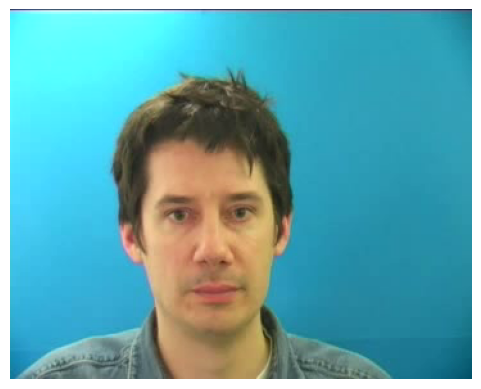

In [14]:
plt.ion()
video_path = "Dataset/s1.mpg_vcd/s1/bbaf2n.mpg"

reader = imageio.get_reader(video_path)

n_frames = 0
for frame in reader:
    n_frames += 1
print("Total number of frames:", n_frames)


fig, ax = plt.subplots()

frame = reader.get_data(0)
img = ax.imshow(frame)
plt.axis('off')  


for frame in reader:
    img.set_data(frame)  
    plt.pause(1/30)      

plt.show()